# EECS 498-007/598-005 Assignment 4-2: RNN, LSTM, and Attention for Image Captioning

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

# Image Captioning with RNNs
In this exercise you will implement a vanilla recurrent neural networks and use them it to train a model that can generate novel captions for images.

## Install starter code
We will continue using the utility functions that we've used for previous assignments: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-n_gdevmn
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-n_gdevmn
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10266 sha256=64320a51b62d99ea9f65887fa975f1ff577542e93b278ea748d08129ed113dad
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9bw7gtb/wheels/35/4e/51/1cfb2b06dbaf252fa9d2f100f19a4a2ed71cc1c013f4fa72a6
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, \
                    tensor_to_image, decode_captions, attention_visualizer
import matplotlib.pyplot as plt
import time

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Microsoft COCO
For this exercise we will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

We have preprocessed the data for you already and saved them into a serialized data file. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words. You can download the file named `coco.pt` (378MB) with the link below and run some useful stats.

You will later use MobileNet v2 to extract features for the images. A few notes on the caption preprocessing:

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is saved in an entry named `vocab` (both `idx_to_token` and `token_to_idx`), and we use the function `decode_captions` from the starter code to convert tensors of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [ ]:
# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (112x112)
# "val_images" - resized validation images (112x112)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

!wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
data_dict = torch.load('coco.pt')

# print out all the keys and values from the data dictionary
for k, v in data_dict.items():
    if type(v) == torch.Tensor:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), v.keys())

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)
assert data_dict['train_images'].size(0) == data_dict['train_captions'].size(0) and \
       data_dict['val_images'].size(0) == data_dict['val_captions'].size(0), \
       'shapes of data mismatch!'

print('\nTrain images shape: ', data_dict['train_images'].shape)
print('Train caption tokens shape: ', data_dict['train_captions'].shape)
print('Validation images shape: ', data_dict['val_images'].shape)
print('Validation caption tokens shape: ', data_dict['val_captions'].shape)
print('total number of caption tokens: ', len(data_dict['vocab']['idx_to_token']))
print('mappings (list) from index to caption token: ', data_dict['vocab']['idx_to_token'])
print('mappings (dict) from caption token to index: ', data_dict['vocab']['token_to_idx'])

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']

--2025-03-18 18:37:25--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘coco.pt’

coco.pt             100%[===================>] 378.21M  2.82MB/s    in 2m 26s  

2025-03-18 18:39:51 (2.59 MB/s) - ‘coco.pt’ saved [396583632/396583632]

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Si

## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function.

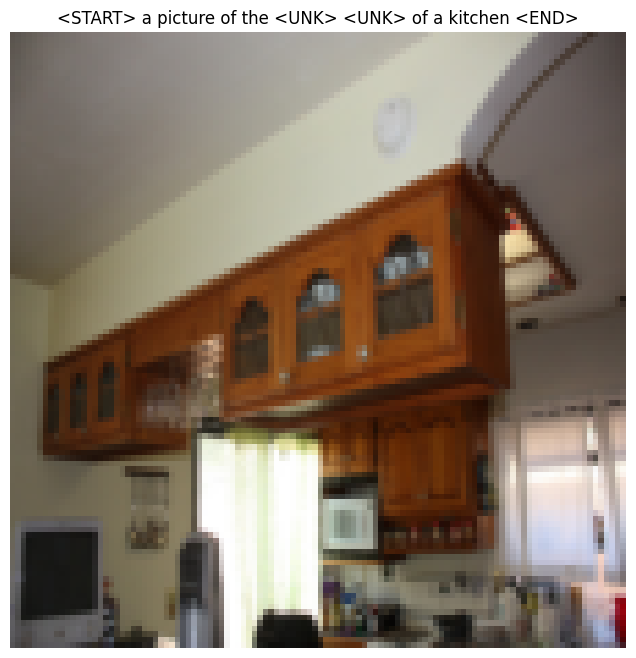

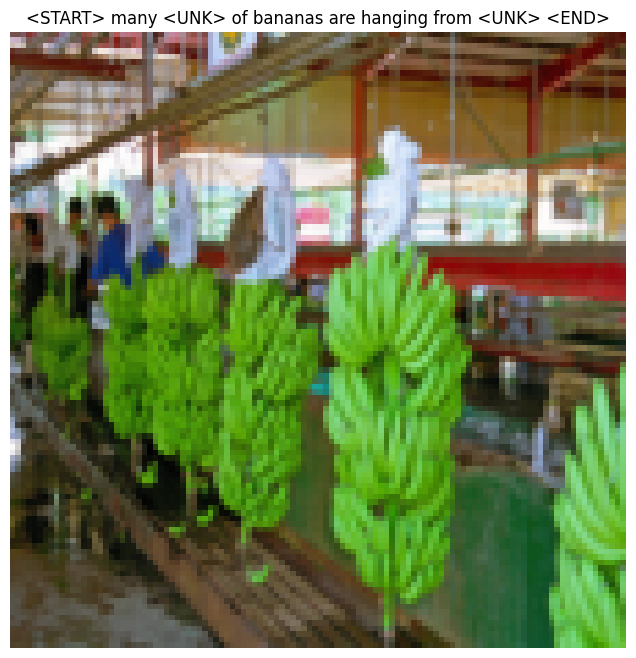

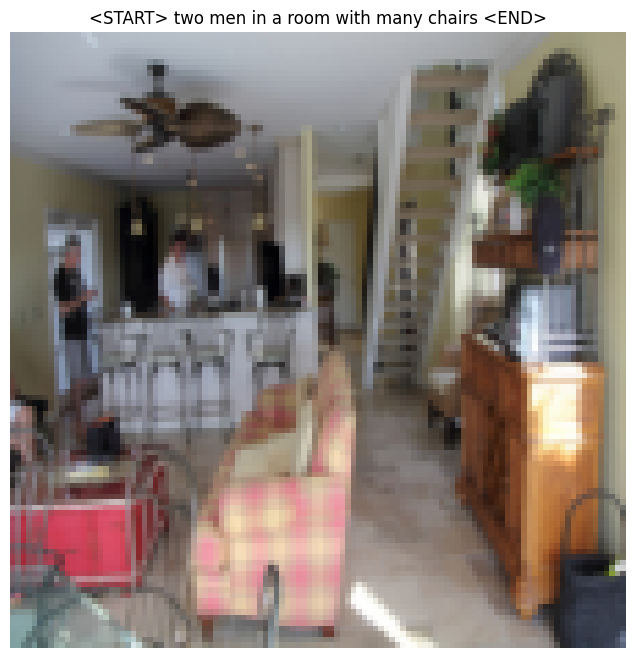

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. We will cover the vanilla RNN model first and later LSTM and attention-based language models.

## Vanilla RNN: step forward
First implement the forward pass for a single timestep of a vanilla recurrent neural network.

In [ ]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # TODO: Implement a single forward step for the vanilla RNN. Store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    ##############################################################################
    # Replace "pass" statement with your code
    activation = x.mm(Wx) + prev_h.mm(Wh) + b
    next_h = torch.tanh(activation)
    cache = (x, prev_h, Wx, Wh, b, next_h)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h, cache

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
N, D, H = 3, 10, 4

x = torch.linspace(-0.4, 0.7, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.2, 0.5, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.1, 0.9, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.3, 0.7, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.2, 0.4, steps=H, **to_double_cuda)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = torch.tensor([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  1.2584843127213472e-08


## Vanilla RNN: step backward
Then implement the backward pass for a single timestep of a vanilla recurrent neural network.

In [ ]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state, of shape (N, H)
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a single step of a vanilla RNN.      #
    #                                                                            #
    # HINT: For the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################
    # Replace "pass" statement with your code
    x, prev_h, Wx, Wh, b, next_h = cache
    dtanh = 1 - next_h**2
    dactivation = dnext_h * dtanh
    db = torch.sum(dactivation, dim=0)
    dWx = x.t().mm(dactivation)
    dWh = prev_h.t().mm(dactivation)
    dx = dactivation.mm(Wx.t())
    dprev_h = dactivation.mm(Wh.t())

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dprev_h, dWx, dWh, db

Run the following to numerically gradient check your implementation. You should see errors on the order of `1e-8` or less.

In [ ]:
fix_random_seed(0)
N, D, H = 4, 5, 6
x = torch.randn(N, D, **to_double_cuda)
h = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = torch.randn(*out.shape, **to_double_cuda)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dnext_h)
dprev_h_num = compute_numeric_gradient(fh, h, dnext_h)
dWx_num = compute_numeric_gradient(fWx, Wx, dnext_h)
dWh_num = compute_numeric_gradient(fWh, Wh, dnext_h)
db_num = compute_numeric_gradient(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.1374784891158466e-10
dprev_h error:  3.259661310256616e-10
dWx error:  6.012991213152496e-09
dWh error:  6.749797054754786e-09
db error:  1.1796017368151223e-10


## Vanilla RNN: forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data. First implement the forward pass by making calls to the `rnn_step_forward` function that you defined earlier.

In [ ]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    # Replace "pass" statement with your code
    N, T, D = x.shape
    H = h0.shape[1]
    h = torch.zeros(N, T, H, device=x.device, dtype=x.dtype)
    cache = []
    prev_h = h0
    for t in range(T):
        next_h, step_cache = rnn_step_forward(x[:, t, :], prev_h, Wx, Wh, b)
        h[:, t, :] = next_h
        cache.append(step_cache)
        prev_h = next_h
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

Run the following to check your implementation. You should see errors on the order of `1e-6` or less.

In [ ]:
N, T, D, H = 2, 3, 4, 5

x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.3, 0.1, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.4, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.4, 0.1, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.7, 0.1, steps=H, **to_double_cuda)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = torch.tensor([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]], **to_double_cuda)
print('h error: ', rel_error(expected_h, h))

h error:  1.5456933554956015e-07


## Vanilla RNN: backward
Implement the backward pass for a vanilla RNN in the function `rnn_backward`. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier.

In [ ]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H).

    NOTE: 'dh' contains the upstream gradients produced by the
    individual loss functions at each timestep, *not* the gradients
    being passed between timesteps (which you'll have to compute yourself
    by calling rnn_step_backward in a loop).

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a vanilla RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above. You can use a for loop to help compute the backward pass.   #
    ##############################################################################
    # Replace "pass" statement with your code
    N, T, H = dh.shape
    x, _, Wx, Wh, _, _ = cache[0]
    D = x.shape[1]

    dx = torch.zeros(N, T, D, device=dh.device, dtype=dh.dtype)
    dWx = torch.zeros_like(Wx)
    dWh = torch.zeros_like(Wh)
    db = torch.zeros(H, device=dh.device, dtype=dh.dtype)
    dprev_h = torch.zeros(N, H, device=dh.device, dtype=dh.dtype)

    for t in reversed(range(T)):
        dnext_h = dh[:, t, :] + dprev_h
        step_dx, dprev_h, step_dWx, step_dWh, step_db = rnn_step_backward(dnext_h, cache[t])
        dx[:, t, :] = step_dx
        dWx += step_dWx
        dWh += step_dWh
        db += step_db

    dh0 = dprev_h

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dh0, dWx, dWh, db

 You should see errors on the order of 1e-7 or less.

In [ ]:
fix_random_seed(0)

N, D, T, H = 2, 3, 10, 5

x = torch.randn(N, T, D, **to_double_cuda)
h0 = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
dh0_num = compute_numeric_gradient(fh0, h0, dout)
dWx_num = compute_numeric_gradient(fWx, Wx, dout)
dWh_num = compute_numeric_gradient(fWh, Wh, dout)
db_num = compute_numeric_gradient(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.7115546610533173e-09
dh0 error:  2.1255646040316826e-10
dWx error:  1.0323317653845348e-09
dWh error:  1.6482165438816203e-09
db error:  3.1310319016185146e-10


## Vanilla RNN: backward with autograd
Now it's time to introduce the lifesaver PyTorch Automatic Differantiation package - `torch.autograd`!

`torch.autograd` provides classes and functions implementing **automatic differentiation** of arbitrary scalar valued functions. It requires minimal changes to the existing code - if you pass tensors with `requires_grad=True` to the forward function you wrote earlier, you can just call `.backward(gradient=grad)` on the output to compute gradients on the input and weights.

Now we can compare the manual backward pass with the autograd backward pass. **Read through the following.**  You should get a relative error less than 1e-12.

In [ ]:
fix_random_seed(0)

N, D, T, H = 2, 3, 10, 5

# set requires_grad=True
x = torch.randn(N, T, D, **to_double_cuda, requires_grad=True)
h0 = torch.randn(N, H, **to_double_cuda, requires_grad=True)
Wx = torch.randn(D, H, **to_double_cuda, requires_grad=True)
Wh = torch.randn(H, H, **to_double_cuda, requires_grad=True)
b = torch.randn(H, **to_double_cuda, requires_grad=True)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# manual backward
with torch.no_grad():
  dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

# backward with autograd
out.backward(dout) # the magic happens here!
dx_auto, dh0_auto, dWx_auto, dWh_auto, db_auto = \
  x.grad, h0.grad, Wx.grad, Wh.grad, b.grad

print('dx error: ', rel_error(dx_auto, dx))
print('dh0 error: ', rel_error(dh0_auto, dh0))
print('dWx error: ', rel_error(dWx_auto, dWx))
print('dWh error: ', rel_error(dWh_auto, dWh))
print('db error: ', rel_error(db_auto, db))

dx error:  9.310039038552183e-15
dh0 error:  3.027536026905238e-16
dWx error:  2.5341134542838565e-15
dWh error:  3.86060105826211e-15
db error:  2.6536631167201656e-16


## RNN Module
We can now wrap the vanilla RNN we wrote into an `nn.Module`. `nn.Module` is a base class for all neural network modules, more details regarding its attributes, functions, and methods could be found [here](https://pytorch.org/docs/stable/nn.html?highlight=module#torch.nn.Module).

Here we want to set up a module for RNN, where function `__init__` sets up weight and biases, and function `forward` call the `rnn_forward` function from before.

**We have written this part for you but you are highly recommended to go through the code as you will write `modules` on your own later.**

All the implementation will be with `autograd` and `nn.Module` going forward.

In [ ]:
class RNN(nn.Module):
  """
  A single-layer vanilla RNN module.

  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a RNN.
    Model parameters to initialize:
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)
    """
    super().__init__()

    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size,
                       device=device, dtype=dtype))

  def forward(self, x, h0):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)

    Outputs:
    - hn: The hidden state output
    """
    hn, _ = rnn_forward(x, h0, self.Wx, self.Wh, self.b)
    return hn

  def step_forward(self, x, prev_h):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    """
    next_h, _ = rnn_step_forward(x, prev_h, self.Wx, self.Wh, self.b)
    return next_h

# RNN for image captioning
You will implement a few necessary tools and layers in order to build an image captioning model (class `CaptioningRNN`).

## Image Feature Extraction
Here, we use [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. For vanilla RNN and LSTM, we use the pooled CNN feature activation. For Attention LSTM, we use the CNN feature activation map after the last convolution layer.

In [ ]:
# !pip install torchsummary

class FeatureExtractor(object):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, pooling=False, verbose=False,
               device='cpu', dtype=torch.float32):

    from torchvision import transforms, models
    from torchsummary import summary
    self.preprocess = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    self.device, self.dtype = device, dtype
    self.mobilenet = models.mobilenet_v2(pretrained=True).to(device)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier

    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(4, 4)) # input: N x 1280 x 4 x 4

    self.mobilenet.eval()
    if verbose:
      summary(self.mobilenet, (3, 112, 112))

  def extract_mobilenet_feature(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape N x 3 x 112 x 112

    Outputs:
    - feat: Image feature, of shape N x 1280 (pooled) or N x 1280 x 4 x 4
    """
    num_img = img.shape[0]

    img_prepro = []
    for i in range(num_img):
      img_prepro.append(self.preprocess(img[i].type(self.dtype).div(255.)))
    img_prepro = torch.stack(img_prepro).to(self.device)

    with torch.no_grad():
      feat = []
      process_batch = 500
      for b in range(math.ceil(num_img/process_batch)):
        feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                                ).squeeze(-1).squeeze(-1)) # forward and squeeze
      feat = torch.cat(feat)

      # add l2 normalization
      F.normalize(feat, p=2, dim=1)

    if verbose:
      print('Output feature shape: ', feat.shape)

    return feat

Now, let's see what's inside MobileNet v2. Assume we have a 3x112x112 image input. We pass argument `pooling=True` to the model so the CNN activation is spatially-pooled from `1280x4x4` to `1280`.

In [ ]:
model = FeatureExtractor(pooling=True, verbose=True, device='cpu')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 124MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
             ReLU6-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]             288
       BatchNorm2d-5           [-1, 32, 56, 56]              64
             ReLU6-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             512
       BatchNorm2d-8           [-1, 16, 56, 56]              32
  InvertedResidual-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           1,536
      BatchNorm2d-11           [-1, 96, 56, 56]             192
            ReLU6-12           [-1, 96, 56, 56]               0
           Conv2d-13           [-1, 96, 28, 28]             864
      BatchNorm2d-14           [-1, 96,

## Word embedding
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Implement the module `WordEmbedding` to convert words (represented by integers) into vectors.

In [ ]:
class WordEmbedding(nn.Module):
  """
  Simplified version of torch.nn.Embedding.

  We operate on minibatches of size N where
  each sequence has length T. We assume a vocabulary of V words, assigning each
  word to a vector of dimension D.

  Inputs:
  - x: Integer array of shape (N, T) giving indices of words. Each element idx
    of x muxt be in the range 0 <= idx < V.

  Returns a tuple of:
  - out: Array of shape (N, T, D) giving word vectors for all input words.
  """
  def __init__(self, vocab_size, embed_size,
               device='cpu', dtype=torch.float32):
      super().__init__()

      # Register parameters
      self.W_embed = Parameter(torch.randn(vocab_size, embed_size,
                         device=device, dtype=dtype).div(math.sqrt(vocab_size)))

  def forward(self, x):

      out = None
      ##############################################################################
      # TODO: Implement the forward pass for word embeddings.                      #
      #                                                                            #
      # HINT: This can be done in one line using PyTorch's array indexing.           #
      ##############################################################################
      # Replace "pass" statement with your code
      out = self.W_embed[x]
      ##############################################################################
      #                               END OF YOUR CODE                             #
      ##############################################################################
      return out

Run the following to check your implementation. You should see an error on the order of `1e-7` or less.

In [ ]:
N, T, V, D = 2, 4, 5, 3

x = torch.tensor([[0, 3, 1, 2], [2, 1, 0, 3]], **to_long_cuda)
W = torch.linspace(0, 1, steps=V*D, **to_double_cuda).reshape(V, D)

model_emb = WordEmbedding(V, D, **to_double_cuda)
model_emb.W_embed.data.copy_(W)
out = model_emb(x)
expected_out = torch.tensor([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]], **to_double_cuda)

print('out error: ', rel_error(expected_out, out))

out error:  1.9999999989472883e-08


## (Temporal) Affine layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. This could be easily done with the [`nn.Linear`](https://pytorch.org/docs/master/nn.html#torch.nn.Linear) module. It can also work as a regular affine layer, like the one you have implemented from previous assignments. Run the following examples to see how it works. You will intensively use `nn.Linear` later.

In [ ]:
fix_random_seed(0)

N, T, D, M = 2, 3, 4, 3

w = torch.linspace(-0.2, 0.4, steps=D*M, **to_double_cuda).reshape(D, M).permute(1, 0)
b = torch.linspace(-0.4, 0.1, steps=M, **to_double_cuda)

temporal_affine = nn.Linear(D, M).to(**to_double_cuda)
temporal_affine.weight.data.copy_(w)
temporal_affine.bias.data.copy_(b)

# For regular affine layer
x = torch.linspace(-0.1, 0.3, steps=N*D, **to_double_cuda).reshape(N, D)
out = temporal_affine(x)
print('affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[-0.35584416, -0.10896104,  0.13792208],
                     [-0.31428571, -0.01753247,  0.27922078]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))


# For temporal affine layer
x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
out = temporal_affine(x)
print('\ntemporal affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[[-0.39920949, -0.16533597,  0.06853755],
                             [-0.38656126, -0.13750988,  0.11154150],
                             [-0.37391304, -0.10968379,  0.15454545]],
                            [[-0.36126482, -0.08185771,  0.19754941],
                             [-0.34861660, -0.05403162,  0.24055336],
                             [-0.33596838, -0.02620553,  0.28355731]]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))

affine layer - input shape: torch.Size([2, 4]), output shape: torch.Size([2, 3])
dx error:  1.4074072067881048e-07

temporal affine layer - input shape: torch.Size([2, 3, 4]), output shape: torch.Size([2, 3, 3])
dx error:  1.3725492070076203e-07


## Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `ignore_index` that tells it which index in caption should be ignored when computing the loss.

In [ ]:
def temporal_softmax_loss(x, y, ignore_index=NULL_index):
    """
    A temporal version of softmax loss for use in RNNs. We assume that we are
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. We use a cross-entropy loss at each
    timestep, *summing* the loss over all timesteps and *averaging* across the
    minibatch.

    As an additional complication, we may want to ignore the model output at some
    timesteps, since sequences of different length may have been combined into a
    minibatch and padded with NULL tokens. The optional ignore_index argument
    tells us which elements in the caption should not contribute to the loss.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V

    Returns a tuple of:
    - loss: Scalar giving loss
    """
    loss = None

    ##############################################################################
    # TODO: Implement the temporal softmax loss function.                        #
    #                                                                            #
    # REQUIREMENT: This part MUST be done in one single line of code!            #
    #                                                                            #
    # HINT: Look up the function torch.functional.cross_entropy, set             #
    # ignore_index to the variable ignore_index (i.e., index of NULL) and        #
    # set reduction to either 'sum' or 'mean' (avoid using 'none' for now).      #
    #                                                                            #
    # We use a cross-entropy loss at each timestep, *summing* the loss over      #
    # all timesteps and *averaging* across the minibatch.                        #
    ##############################################################################
    # Replace "pass" statement with your code
    loss = F.cross_entropy(x.reshape(-1, x.shape[-1]), y.reshape(-1), ignore_index=ignore_index, reduction='sum') / x.shape[0]
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return loss

### Sanity check

In [ ]:
def check_loss(N, T, V, p):
    x = 0.001 * torch.randn(N, T, V, **to_double_cuda)
    y = torch.randint(V, size=(N, T), **to_long_cuda)
    mask = torch.rand(N, T, **to_double_cuda)
    y[mask > p] = 0
    print(temporal_softmax_loss(x, y).item())

check_loss(1000, 1, 10, 1.0)   # Should be about 2.00-2.11
check_loss(1000, 10, 10, 1.0)  # Should be about 20.6-21.0
check_loss(5000, 10, 10, 0.1) # Should be about 2.00-2.11

## Captioning Module
Now we are wrapping everything into the captioning module. Implement the `__init__` function for initialization and the `captioning_forward` for the forward pass. For now you only need to implement for the case where `cell_type='rnn'`, indicating vanialla RNNs; you will implement the `LSTM` case and `AttentionLSTM` case later.

In [ ]:
class CaptioningRNN(nn.Module):
    """
    A CaptioningRNN produces captions from images using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.

    You will implement the `__init__` method for model initialization and
    the `forward` method first, then come back for the `sample` method later.
    """
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', device='cpu', dtype=torch.float32):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        super().__init__()
        if cell_type not in {'rnn', 'lstm', 'attention'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self._device = device

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)

        ##########################################################################
        # TODO: Initialize the image captioning module. Refer to the TODO        #
        # in the captioning_forward function on layers you need to create        #
        #                                                                        #
        # Hint: You can use nn.Linear for both                                   #
        # i) output projection (from RNN hidden state to vocab probability) and  #
        # ii) feature projection (from CNN pooled feature to h0)                 #
        #                                                                        #
        # Hint: In FeatureExtractor, set pooling=True to get the pooled CNN      #
        #       feature and pooling=False to get the CNN activation map.         #
        ##########################################################################
        # Replace "pass" statement with your code
        self.input_dim = input_dim
        self.wordvec_dim = wordvec_dim
        self.hidden_dim = hidden_dim

        if self.cell_type=='attention':
          self.feature_extractor = FeatureExtractor(pooling=False)
          self.attention = AttentionLSTM(input_size=self.wordvec_dim, hidden_size=self.hidden_dim).to(self._device)
        else:
          self.feature_extractor = FeatureExtractor(pooling=True)

        self.feature2hid = nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim).to(self._device)
        self.vocab_size = vocab_size

        self.embed = WordEmbedding(vocab_size=self.vocab_size, embed_size=self.wordvec_dim).to(self._device)
        if self.cell_type=='lstm':
          self.lstm = LSTM(input_size=self.wordvec_dim, hidden_size=self.hidden_dim).to(self._device)
        else:
          self.rnn = RNN(input_size=self.wordvec_dim, hidden_size=self.hidden_dim).to(self._device)
        self.hidden2score = nn.Linear(in_features=self.hidden_dim, out_features=self.vocab_size).to(self._device)
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

    def forward(self):
      raise NotImplementedError

    def sample(self):
      raise NotImplementedError

### Forward part
Implement the forward function.

In [ ]:
    def captioning_forward(self, images, captions):
        """
        Compute training-time loss for the RNN. We input images and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss. The backward part will be done by torch.autograd.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - captions: Ground-truth captions; an integer array of shape (N, T + 1) where
          each element is in the range 0 <= y[i, t] < V

        Outputs:
        - loss: A scalar loss
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        loss = 0.0
        ############################################################################
        # TODO: Implement the forward pass for the CaptioningRNN.                  #
        # In the forward pass you will need to do the following:                   #
        # (1) Use an affine transformation to project the image feature to         #
        #     the initial hidden state $h0$ (for RNN/LSTM, of shape (N, H)) or     #
        #     the projected CNN activation input $A$ (for Attention LSTM,          #
        #     of shape (N, H, 4, 4).                                               #
        # (2) Use a word embedding layer to transform the words in captions_in     #
        #     from indices to vectors, giving an array of shape (N, T, W).         #
        # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
        #     process the sequence of input word vectors and produce hidden state  #
        #     vectors for all timesteps, producing an array of shape (N, T, H).    #
        # (4) Use a (temporal) affine transformation to compute scores over the    #
        #     vocabulary at every timestep using the hidden states, giving an      #
        #     array of shape (N, T, V).                                            #
        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
        #     the points where the output word is <NULL>.                          #
        #                                                                          #
        # Do not worry about regularizing the weights or their gradients!          #
        ############################################################################
        # Replace "pass" statement with your code
        input_words = self.embed(captions_in)
        if self.cell_type =='attention':
          features = self.feature_extractor.extract_mobilenet_feature(images.to(self._device)).to(self._device)
          A = self.feature2hid(features.permute(0, 2, 3, 1))
          hiddens = self.attention(x=input_words, A=A.permute(0, 3, 1, 2))
        else:
          features = self.feature_extractor.extract_mobilenet_feature(images.to(self._device)).to(self._device)
          h0s = self.feature2hid(features)
          if self.cell_type == 'lstm':
            hiddens = self.lstm(h0=h0s, x=input_words)
          else:
            hiddens = self.rnn(h0=h0s, x=input_words)
        scores = self.hidden2score(hiddens)
        loss = temporal_softmax_loss(scores, captions_out, ignore_index=NULL_index)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss

    CaptioningRNN.forward = captioning_forward

### Inference part
We will come back to this part later.

In [ ]:
    def sample_caption(self, images, max_length=15):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the image features, and the initial word is the <START>
        token.

        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - max_length: Maximum length T of generated captions

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = images.shape[0]
        captions = self._null * images.new(N, max_length).fill_(1).long()

        if self.cell_type == 'attention':
          attn_weights_all = images.new(N, max_length, 4, 4).fill_(0).float()

        ###########################################################################
        # TODO: Implement test-time sampling for the model. You will need to      #
        # initialize the hidden state of the RNN by applying the learned affine   #
        # transform to the image features. The first word that you feed to  #
        # the RNN should be the <START> token; its value is stored in the         #
        # variable self._start. At each timestep you will need to do to:          #
        # (1) Embed the previous word using the learned word embeddings           #
        # (2) Make an RNN step using the previous hidden state and the embedded   #
        #     current word to get the next hidden state.                          #
        # (3) Apply the learned affine transformation to the next hidden state to #
        #     get scores for all words in the vocabulary                          #
        # (4) Select the word with the highest score as the next word, writing it #
        #     (the word index) to the appropriate slot in the captions variable   #
        #                                                                         #
        # For simplicity, you do not need to stop generating after an <END> token #
        # is sampled, but you can if you want to.                                 #
        #                                                                         #
        # HINT: You will not be able to use the rnn_forward or lstm_forward       #
        # functions; you'll need to call the `step_forward` from the              #
        # RNN/LSTM/AttentionLSTM module in a loop.                                #
        #                                                                         #
        # NOTE: we are still working over minibatches in this function. Also if   #
        # you are using an LSTM, initialize the first cell state to zeros.        #
        # For AttentionLSTM, first project the 1280x4x4 CNN feature activation to #
        # $A$ of shape Hx4x4. The LSTM initial hidden state and cell state        #
        # would both be A.mean(dim=(2, 3)).                                       #
        ###########################################################################
        # Replace "pass" statement with your code

        h = self.affine_transform(images)
        c = torch.zeros_like(h) if self.cell_type == 'lstm' else None

        for t in range(max_length - 1):
            embeds = self.embed(captions[:, t])
            if self.cell_type == 'lstm':
                h, c = self.lstm.step_forward(embeds, h, c)
            else:
                h = self.rnn.step_forward(embeds, h)
            scores = self.hidden2score(h)
            captions[:, t + 1] = scores.argmax(dim=1)


        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        if self.cell_type == 'attention':
          return captions, attn_weights_all.cpu()
        else:
          return captions

    CaptioningRNN.sample = sample_caption

### Sanity check
Run the following to check your forward pass using a small test case; you should see difference on the order of 1e-7 or less.

In [ ]:
fix_random_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          **to_float_cuda) # use float here to be consistent with MobileNet v2


for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 150.6090393066

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  150.60902404785156
expected loss:  150.6090393066
difference:  1.0131390126844053e-07


## Image Captioning solver
Different from the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use the `torch.optim` package to train image captioning models.

We have written this part for you and you need to train the model and generate plots on the training loss.

In [ ]:
def CaptioningTrain(rnn_model, image_data, caption_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(image_data.shape[0] // batch_size)
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      images, captions = image_data[j*batch_size:(j+1)*batch_size], \
                           caption_data[j*batch_size:(j+1)*batch_size]

      loss = rnn_model(images, captions)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

## Overfit small data
Once you have familiarized yourself with the `optim` API used above, run the following to make sure your model overfits a small sample of 50 training examples. You should see a final loss of less than 1.6.

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.3800 time per epoch: 0.9s
(Epoch 1 / 80) loss: 71.5979 time per epoch: 0.5s
(Epoch 2 / 80) loss: 67.2238 time per epoch: 0.5s
(Epoch 3 / 80) loss: 63.0301 time per epoch: 0.5s
(Epoch 4 / 80) loss: 58.7173 time per epoch: 0.5s
(Epoch 5 / 80) loss: 54.2252 time per epoch: 0.5s
(Epoch 6 / 80) loss: 50.1323 time per epoch: 0.5s
(Epoch 7 / 80) loss: 46.7348 time per epoch: 0.5s
(Epoch 8 / 80) loss: 44.1695 time per epoch: 0.5s
(Epoch 9 / 80) loss: 42.3702 time per epoch: 0.5s
(Epoch 10 / 80) loss: 40.9555 time per epoch: 0.5s
(Epoch 11 / 80) loss: 39.6932 time per epoch: 0.5s
(Epoch 12 / 80) loss: 38.4814 time per epoch: 0.5s
(Epoch 13 / 80) loss: 37.4231 time per epoch: 0.5s
(Epoch 14 / 80) loss: 36.4403 time per epoch: 0.5s
(Epoch 15 / 80) loss: 35.5309 time per epoch: 0.5s
(Epoch 16 / 80) loss: 34.7126 time per epoch: 0.5s
(Epoch 17 / 80) loss: 34.0880 time per epoch: 0.6s
(Epoch 18 / 80) loss: 33.4681 time per epoch: 0.7s
(Epoch 19 / 80) 

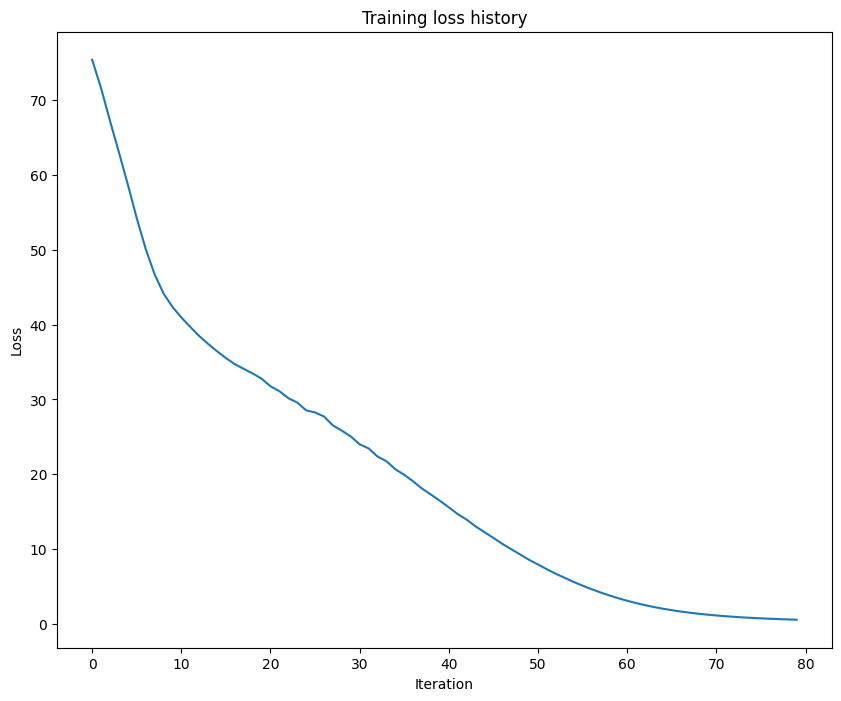

In [ ]:
fix_random_seed(0)

# data input

small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long().cpu()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')


# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

Implement the [`sample`](#scrollTo=v0M8Dq5NEOxN) method in captioning module `CaptioningRNN` for test-time sampling. After doing so, run the following to train a captioning model and sample from the model on both training and validation data.

### Train the net
After you are done implementing the [`sample`](#scrollTo=v0M8Dq5NEOxN) method, perform the training on the entire training set. You should see a final loss less than `2.0`.

learning rate is:  0.001
(Epoch 0 / 60) loss: 45.8403 time per epoch: 176.3s
(Epoch 1 / 60) loss: 40.0454 time per epoch: 175.5s
(Epoch 2 / 60) loss: 36.7927 time per epoch: 174.3s
(Epoch 3 / 60) loss: 34.5757 time per epoch: 174.1s
(Epoch 4 / 60) loss: 32.5174 time per epoch: 174.6s
(Epoch 5 / 60) loss: 30.8038 time per epoch: 177.5s
(Epoch 6 / 60) loss: 29.5489 time per epoch: 174.2s
(Epoch 7 / 60) loss: 27.7974 time per epoch: 175.2s
(Epoch 8 / 60) loss: 26.5034 time per epoch: 176.2s
(Epoch 9 / 60) loss: 25.2916 time per epoch: 175.4s
(Epoch 10 / 60) loss: 24.1860 time per epoch: 173.1s
(Epoch 11 / 60) loss: 23.2164 time per epoch: 174.3s
(Epoch 12 / 60) loss: 22.1066 time per epoch: 175.1s
(Epoch 13 / 60) loss: 21.0890 time per epoch: 175.7s
(Epoch 14 / 60) loss: 20.0096 time per epoch: 176.1s
(Epoch 15 / 60) loss: 19.0185 time per epoch: 175.4s
(Epoch 16 / 60) loss: 18.1165 time per epoch: 175.7s
(Epoch 17 / 60) loss: 17.4097 time per epoch: 175.7s
(Epoch 18 / 60) loss: 16.9939 t

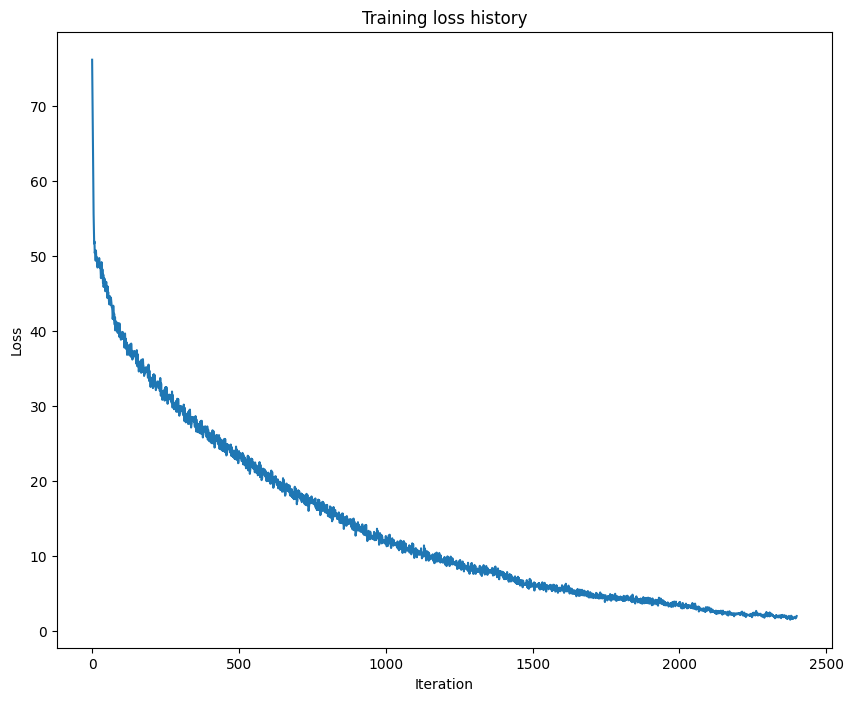

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), device='cpu')
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(rnn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
The samples on training data should be very good; the samples on validation data will probably make less sense.

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. Next, we will implement the LSTM update rule and use it for image captioning.

# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

## LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Don't worry about the backward part! `autograd` will handle it.

In [ ]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn=None, Wattn=None):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    - attn and Wattn are for Attention LSTM only, indicate the attention input and
      embedding weights for the attention input

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    """
    next_h, next_c = None, None
    #############################################################################
    # TODO: Implement the forward pass for a single timestep of an LSTM.        #
    # You may want to use torch.sigmoid() for the sigmoid function.             #
    #############################################################################
    # Replace "pass" statement with your code
    if attn is not None and Wattn is not None:
        a = x.mm(Wx) + prev_h.mm(Wh) + attn.mm(Wattn) + b
    else:
        a = x.mm(Wx) + prev_h.mm(Wh) + b
    H = prev_h.shape[1]
    ai, af, ao, ag = torch.split(a, H, dim=1)

    i = torch.sigmoid(ai)
    f = torch.sigmoid(af)
    o = torch.sigmoid(ao)
    g = torch.tanh(ag)

    next_c = f * prev_c + i * g

    next_h = o * torch.tanh(next_c)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return next_h, next_c

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `1e-7` or less.

In [ ]:
N, D, H = 3, 4, 5
x = torch.linspace(-0.4, 1.2, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N*H, **to_double_cuda).reshape(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4*H, **to_double_cuda)

next_h, next_c = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = torch.tensor([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]], **to_double_cuda)
expected_next_c = torch.tensor([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  1.141082583349966e-08
next_c error:  1.1628624685373283e-08


## LSTM: forward
Implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

Again, don't worry about the backward part! `autograd` will handle it.

In [ ]:
def lstm_forward(x, h0, Wx, Wh, b):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    """
    h = None
    c0 = torch.zeros_like(h0) # we provide the intial cell state c0 here for you!
    #############################################################################
    # TODO: Implement the forward pass for an LSTM over an entire timeseries.   #
    # You should use the lstm_step_forward function that you just defined.      #
    #############################################################################
    # Replace "pass" statement with your code
    N, T, D = x.shape
    H = h0.shape[1]

    h = torch.zeros(N, T, H, device=x.device, dtype=x.dtype)

    prev_h = h0

    for t in range(T):
        xt = x[:, t, :]
        next_h, c0 = lstm_step_forward(xt, prev_h, c0, Wx, Wh, b)
        h[:, t, :] = next_h
        prev_h = next_h

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return h

When you are done, run the following to check your implementation. You should see an error on the order of `1e-7` or less.

In [ ]:
N, D, H, T = 2, 5, 4, 3
x = torch.linspace(-0.4, 0.6, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.4, 0.8, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.9, steps=4*D*H, **to_double_cuda).reshape(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4*H*H, **to_double_cuda).reshape(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4*H, **to_double_cuda)

h = lstm_forward(x, h0, Wx, Wh, b)

expected_h = torch.tensor([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]], **to_double_cuda)

print('h error: ', rel_error(expected_h, h))

h error:  1.7221073421386268e-07


## LSTM Module

We can now wrap the LSTM functions we wrote into an nn.Module.

In [ ]:
class LSTM(nn.Module):
  """
  This is our single-layer, uni-directional LSTM module.

  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a LSTM.
    Model parameters to initialize:
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    """
    super().__init__()

    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size*4,
                       device=device, dtype=dtype))

  def forward(self, x, h0):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)

    Outputs:
    - hn: The hidden state output
    """
    hn = lstm_forward(x, h0, self.Wx, self.Wh, self.b)
    return hn

  def step_forward(self, x, prev_h, prev_c):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)
    - prev_c: The previous cell state, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    - next_c: The next cell state, of shape (N, H)
    """
    next_h, next_c = lstm_step_forward(x, prev_h, prev_c, self.Wx, self.Wh, self.b)
    return next_h, next_c

## LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the [`init`](#scrollTo=XWrmaSZaUxqX) method in class `CaptioningRNN` **ONLY** to also handle the case where `self.cell_type` is `lstm`. **This should require adding less than 5 lines of code.**

Once you have done so, run the following to check your implementation. You should see a difference on the order of `1e-7` or less.

In [ ]:
fix_random_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          **to_float_cuda)

for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 146.3161468505

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loss:  146.31614685058594
expected loss:  146.3161468505
difference:  0.0


## Overfit small data
We have written this part for you. Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than `4` after 80 epochs.

learning rate is:  0.01
(Epoch 0 / 80) loss: 74.8825 time per epoch: 1.2s
(Epoch 1 / 80) loss: 71.6916 time per epoch: 1.3s
(Epoch 2 / 80) loss: 52.7698 time per epoch: 0.6s
(Epoch 3 / 80) loss: 48.1927 time per epoch: 0.7s
(Epoch 4 / 80) loss: 47.5791 time per epoch: 1.3s
(Epoch 5 / 80) loss: 45.4999 time per epoch: 1.2s
(Epoch 6 / 80) loss: 43.7835 time per epoch: 0.8s
(Epoch 7 / 80) loss: 42.5704 time per epoch: 0.6s
(Epoch 8 / 80) loss: 41.2229 time per epoch: 0.5s
(Epoch 9 / 80) loss: 39.5320 time per epoch: 0.5s
(Epoch 10 / 80) loss: 38.1387 time per epoch: 0.6s
(Epoch 11 / 80) loss: 36.6653 time per epoch: 0.5s
(Epoch 12 / 80) loss: 34.9966 time per epoch: 0.5s
(Epoch 13 / 80) loss: 33.0747 time per epoch: 0.6s
(Epoch 14 / 80) loss: 30.9156 time per epoch: 0.6s
(Epoch 15 / 80) loss: 28.7581 time per epoch: 0.6s
(Epoch 16 / 80) loss: 26.8336 time per epoch: 0.5s
(Epoch 17 / 80) loss: 25.0324 time per epoch: 0.6s
(Epoch 18 / 80) loss: 22.4107 time per epoch: 0.5s
(Epoch 19 / 80) l

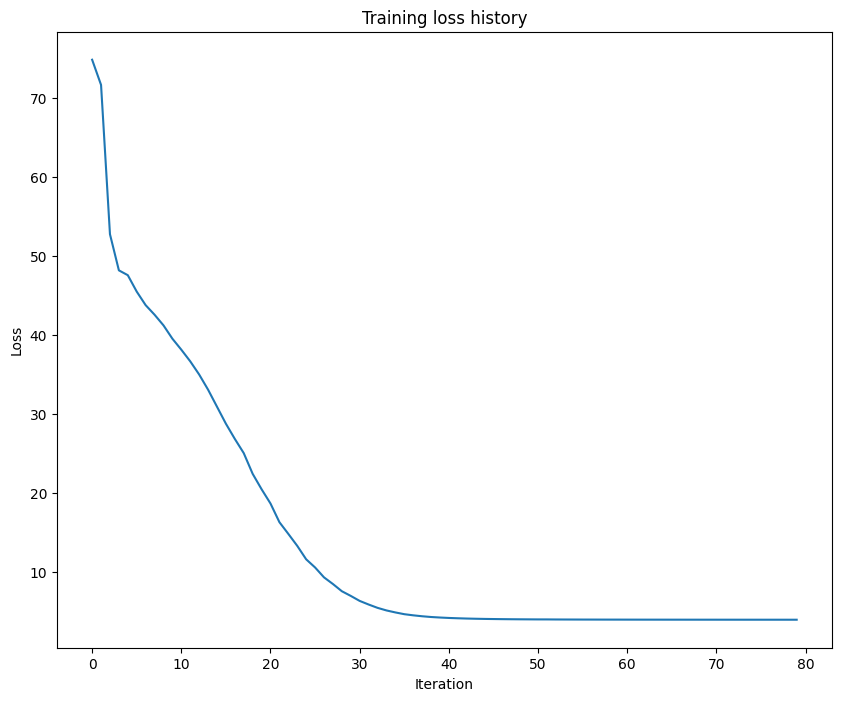

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-2]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Modify the [`sample`](#scrollTo=v0M8Dq5NEOxN) method in class `CaptioningRNN` to handle the case where `self.cell_type` is `lstm`. **This should take fewer than 10 lines of code.**

When you are done, run the following to train a captioning model and sample from your the model on some training and validation set samples.

### Train the net
Now, perform the training on the entire training set. You should see a final loss less than `2.8`.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 194MB/s]


learning rate is:  0.001
(Epoch 0 / 60) loss: 48.2639 time per epoch: 205.2s
(Epoch 1 / 60) loss: 43.1463 time per epoch: 197.4s
(Epoch 2 / 60) loss: 39.2377 time per epoch: 200.6s
(Epoch 3 / 60) loss: 37.4748 time per epoch: 203.0s
(Epoch 4 / 60) loss: 36.0780 time per epoch: 202.9s
(Epoch 5 / 60) loss: 34.8386 time per epoch: 203.8s
(Epoch 6 / 60) loss: 33.7665 time per epoch: 205.5s
(Epoch 7 / 60) loss: 32.8665 time per epoch: 203.6s
(Epoch 8 / 60) loss: 32.1420 time per epoch: 205.5s
(Epoch 9 / 60) loss: 31.3131 time per epoch: 201.8s
(Epoch 10 / 60) loss: 30.6346 time per epoch: 205.4s
(Epoch 11 / 60) loss: 29.9908 time per epoch: 207.5s
(Epoch 12 / 60) loss: 29.3180 time per epoch: 205.9s
(Epoch 13 / 60) loss: 28.6014 time per epoch: 206.8s
(Epoch 14 / 60) loss: 28.0648 time per epoch: 206.7s
(Epoch 15 / 60) loss: 27.3968 time per epoch: 207.2s
(Epoch 16 / 60) loss: 26.6876 time per epoch: 207.1s
(Epoch 17 / 60) loss: 26.0587 time per epoch: 205.2s
(Epoch 18 / 60) loss: 25.6795 t

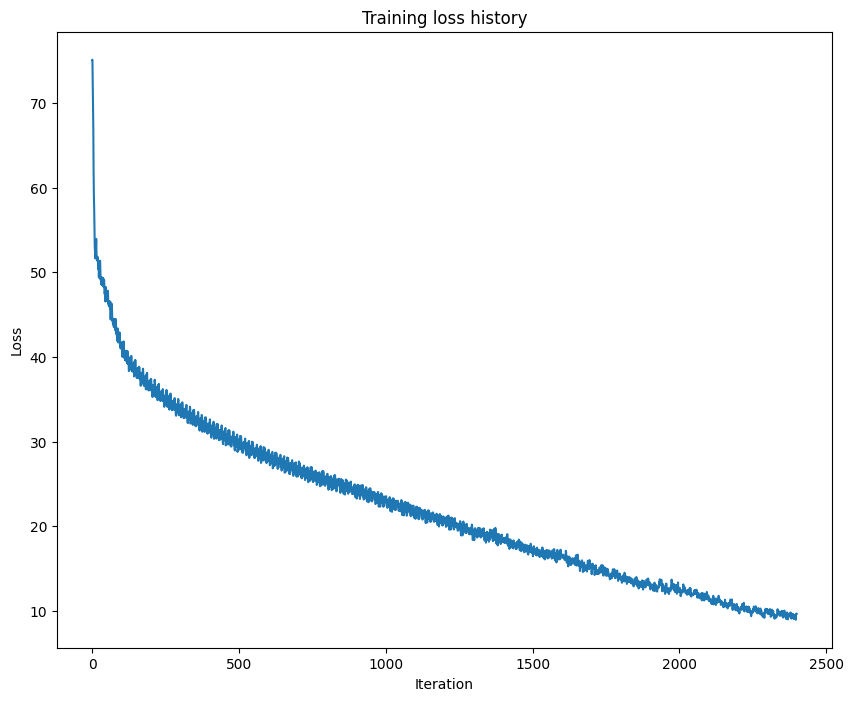

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train).long()
small_image_data = data_dict['train_images'][sample_idx]
small_caption_data = data_dict['train_captions'][sample_idx]

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256
          )

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(lstm_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
As with the RNN, the samples on training data should be very good; the samples on validation data will probably make less sense.

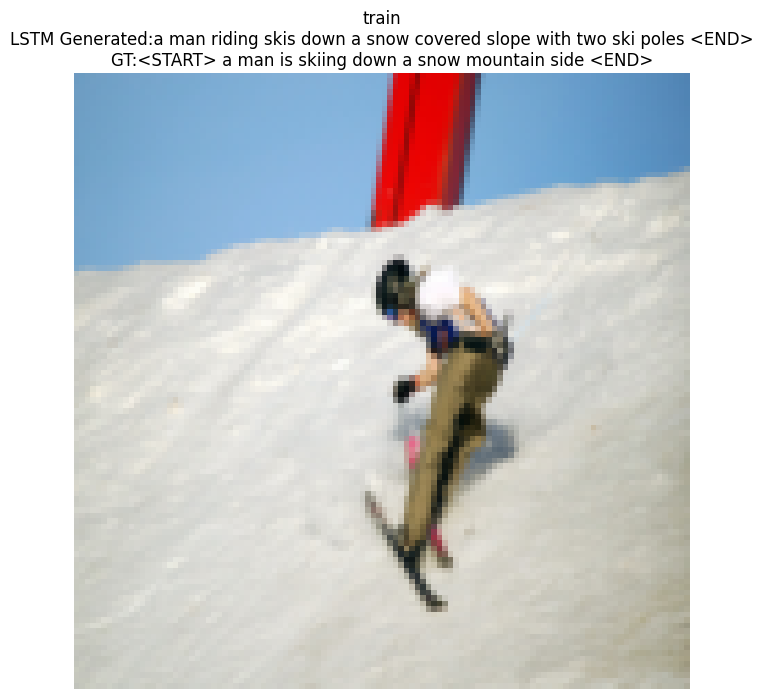

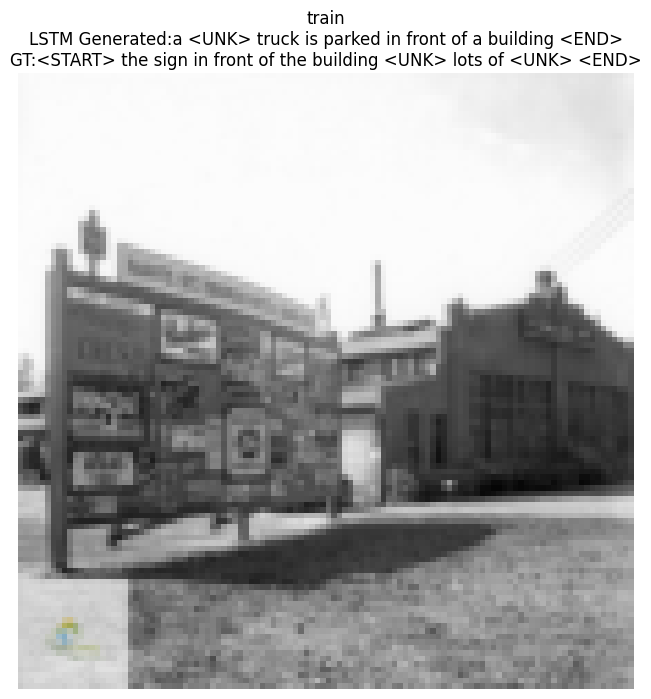

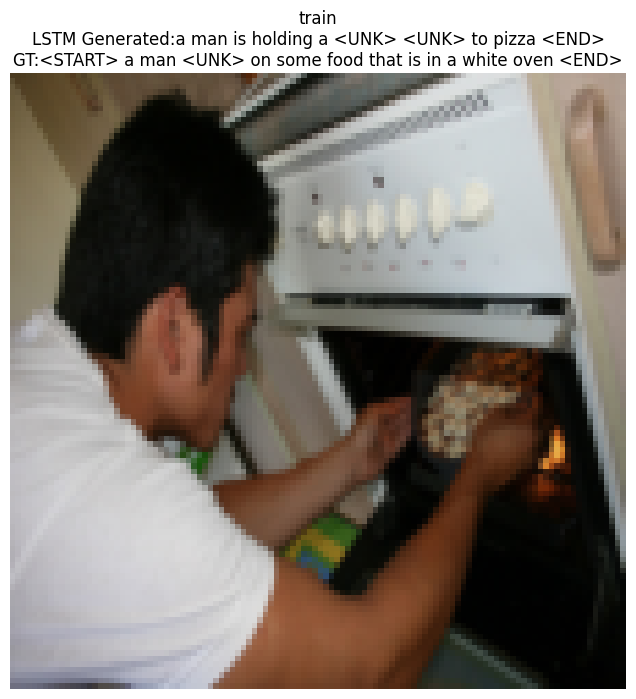

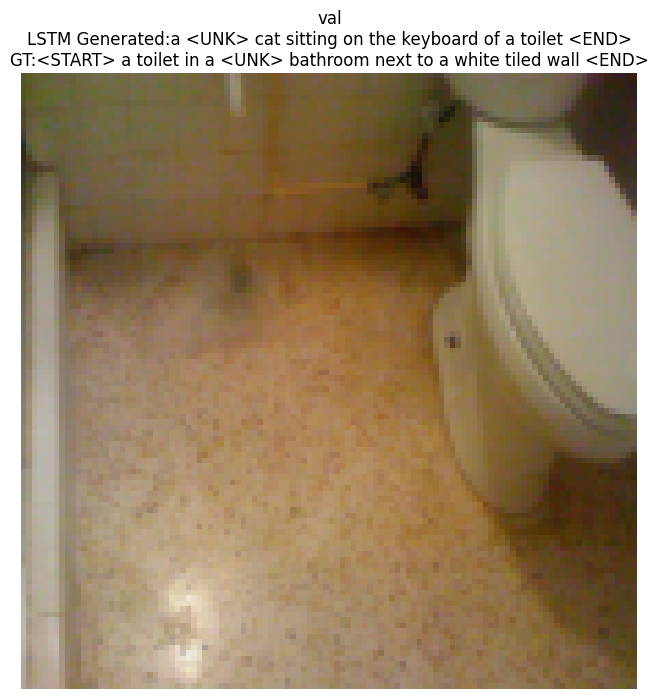

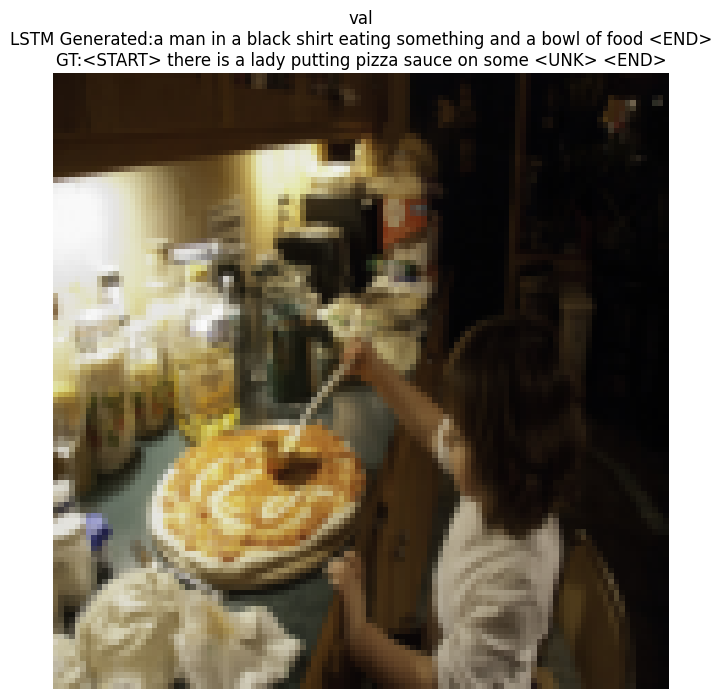

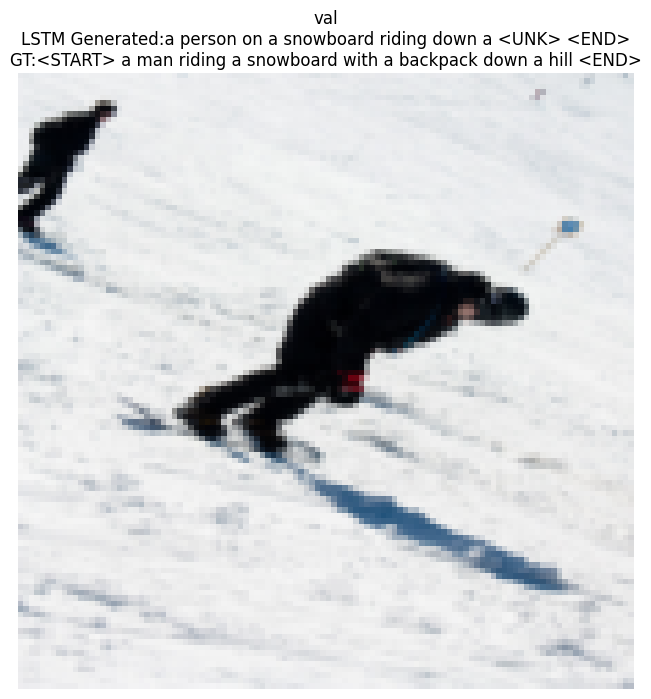

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  lstm_model.eval()
  generated_captions = lstm_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nLSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Attention LSTM
Attention LSTM essentially adds an attention input $x_{attn}^t\in\mathbb{R}^H$ into LSTM, along with $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$.

To get the attention input $x_{attn}^t$, here we adopt a method called `scaled dot-product attention`, as covered in the lecture. We first project the CNN feature activation from $\mathbb{R}^{1280\times4\times4}$ to $\mathbb{R}^{H\times4\times4}$ using an affine layer. Given the projected activation $A\in \mathbb{R}^{H\times4\times4}$ and the LSTM hidden state from the previous time step $h_{t-1}$, we formuate the attention weights on $A$ at time step $t$ as $M_{attn}^t=h_{t-1}A/\sqrt{H} \in \mathbb{R}^{4\times4}$.

To simplify the formuation here, we flatten the spatial dimensions of $A$ and $M_{attn}^t$ which gives $\tilde{A}\in \mathbb{R}^{H\times16}$ and $\tilde{M^t}_{attn}=h_{t-1}A\in \mathbb{R}^{16}$.
We add a **`softmax`** activation function on $\tilde{M^t}_{attn}$ so that the attention weights at each time step are normalized and sum up to one.

The attention embedding given the attention weights is then $x_{attn}^t=\tilde{A}\tilde{M^t}_{attn} \in\mathbb{R}^H$.

You will implement a batch version of the attention layer we have described here.

## Scaled dot-product attention
Implement the scaled dot-product attention function. Given the LSTM hidden state from the previous time step `prev_h` (or $h_{t-1}$) and the projected CNN feature activation `A`, compute the attention weights `attn_weights` (or $\tilde{M^t}_{attn}$ with a reshaping to $\mathbb{R}^{4\times4}$) attention embedding output `attn` (or $x_{attn}^t$) using the formulation we provided.

In [ ]:
def dot_product_attention(prev_h, A):
    """
    A simple scaled dot-product attention layer.
    Inputs:
    - prev_h: The LSTM hidden state from the previous time step, of shape (N, H)
    - A: **Projected** CNN feature activation, of shape (N, H, 4, 4),
         where H is the LSTM hidden state size

    Outputs:
    - attn: Attention embedding output, of shape (N, H)
    - attn_weights: Attention weights, of shape (N, 4, 4)

    """
    N, H, D_a, _ = A.shape

    attn, attn_weights = None, None
    #############################################################################
    # TODO: Implement the scaled dot-product attention we described earlier.    #
    # You will use this function for `attention_forward` and `sample_caption`   #
    # HINT: Make sure you reshape attn_weights back to (N, 4, 4)!               #
    #############################################################################
    # Replace "pass" statement with your code
    A_flat = A.view(N, H, -1)
    attn_weights = torch.bmm(prev_h.unsqueeze(1), A_flat).squeeze(1)
    scaling_factor = torch.sqrt(torch.tensor(H, device=attn_weights.device))
    attn_weights_scaled = attn_weights / scaling_factor
    attn_weights_softmax = torch.softmax(attn_weights_scaled, dim=1)
    attn_weights = attn_weights_softmax.view(N, D_a, D_a)
    attn = torch.bmm(A_flat, attn_weights_softmax.unsqueeze(2)).squeeze(2)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return attn, attn_weights

When you are done, run the following to check your implementation. You should see an error on the order of `1e-7` or less.

In [ ]:
N, H = 2, 5
D_a = 4

prev_h = torch.linspace(-0.4, 0.6, steps=N*H).reshape(N, H)
A = torch.linspace(-0.4, 1.8, steps=N*H*D_a*D_a).reshape(N, H, D_a, D_a)

attn, attn_weights = dot_product_attention(prev_h, A)

expected_attn = torch.tensor([[-0.29784344, -0.07645979,  0.14492386,  0.36630751,  0.58769115],
        [ 0.81412643,  1.03551008,  1.25689373,  1.47827738,  1.69966103]])
expected_attn_weights = torch.tensor([[[0.06511126, 0.06475411, 0.06439892, 0.06404568],
         [0.06369438, 0.06334500, 0.06299754, 0.06265198],
         [0.06230832, 0.06196655, 0.06162665, 0.06128861],
         [0.06095243, 0.06061809, 0.06028559, 0.05995491]],

        [[0.05717142, 0.05784357, 0.05852362, 0.05921167],
         [0.05990781, 0.06061213, 0.06132473, 0.06204571],
         [0.06277517, 0.06351320, 0.06425991, 0.06501540],
         [0.06577977, 0.06655312, 0.06733557, 0.06812722]]])

print('attn error: ', rel_error(expected_attn, attn))
print('attn_weights error: ', rel_error(expected_attn_weights, attn_weights))

attn error:  1.028206284559019e-07
attn_weights error:  2.2129698606931925e-07


## Attention LSTM: step forward

Modify the [`lstm_step_forward`](#scrollTo=t4DNkZYevMMc) function from earlier to support the extra attention input `attn` (or $x_{attn}$) and its embedding weight matrix `Wattn` (or $W_{attn}$) in the LSTM cell. Hence, at each timestep the *activation vector* $a\in\mathbb{R}^{4H}$ in LSTM cell is formulated as:

$a=W_xx_t + W_hh_{t-1}+W_{attn}x_{attn}^t+b$.


**This should require adding less than 5 lines of code.**

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `1e-8` or less.

In [ ]:
N, D, H = 3, 4, 5

x = torch.linspace(-0.4, 1.2, steps=N*D).reshape(N, D)
prev_h = torch.linspace(-0.3, 0.7, steps=N*H).reshape(N, H)
prev_c = torch.linspace(-0.4, 0.9, steps=N*H).reshape(N, H)
Wx = torch.linspace(-2.1, 1.3, steps=4*D*H).reshape(D, 4 * H)
Wh = torch.linspace(-0.7, 2.2, steps=4*H*H).reshape(H, 4 * H)
b = torch.linspace(0.3, 0.7, steps=4*H)
attn = torch.linspace(0.6, 1.8, steps=N*H).reshape(N, H)
Wattn = torch.linspace(1.3, 4.2, steps=4*H*H).reshape(H, 4 * H)


next_h, next_c = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn, Wattn)

expected_next_h = torch.tensor([
    [0.53704256, 0.59980774, 0.65596820, 0.70569729, 0.74932626],
    [0.78729857, 0.82010653, 0.84828362, 0.87235677, 0.89283167],
    [0.91017981, 0.92483119, 0.93717126, 0.94754073, 0.95623746]])
expected_next_c = torch.tensor([
    [0.59999328, 0.69285041, 0.78570758, 0.87856479, 0.97142202],
    [1.06428558, 1.15714276, 1.24999992, 1.34285708, 1.43571424],
    [1.52857143, 1.62142857, 1.71428571, 1.80714286, 1.90000000]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  1.1098683216914651e-07
next_c error:  1.120087489425714e-07


## Attention LSTM: forward


Now, implement the `attention_forward` function to run an Attention LSTM forward on an entire timeseries of data. You will have to use the `dot_product_attention` function and the `lstm_step_forward` function you implemented.

Again, don't worry about the backward part! `autograd` will handle it.

In [ ]:
def attention_forward(x, A, Wx, Wh, Wattn, b):
    """
    h0 and c0 are same initialized as the global image feature (meanpooled A)
    For simplicity, we implement scaled dot-product attention, which means in
    Eq. 4 of the paper (https://arxiv.org/pdf/1502.03044.pdf),
    f_{att}(a_i, h_{t−1}) equals to the scaled dot product of a_i and h_{t-1}.

    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - A: **Projected** activation map, of shape (N, H, 4, 4)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - Wattn: Weights for attention-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    """

    h = None

    # The initial hidden state h0 and cell state c0 are initialized differently in
    # Attention LSTM from the original LSTM and hence we provided them for you.
    h0 = A.mean(dim=(2, 3)) # Initial hidden state, of shape (N, H)
    c0 = h0 # Initial cell state, of shape (N, H)

    #############################################################################
    # TODO: Implement the forward pass for an LSTM over an entire timeseries.   #
    # You should use the lstm_step_forward function and dot_product_attention   #
    # function that you just defined.                                           #
    #############################################################################
    # Replace "pass" statement with your code
    N, T, H = x.shape[0], x.shape[1], h0.shape[1]
    h = torch.zeros(N, T, H, device=x.device, dtype=x.dtype)
    prev_h = A.mean(dim=(2, 3))
    prev_c = prev_h.clone()
    for t in range(min(T, x.shape[1])):
        xt = x[:, t, :]
        attn, attn_weights = dot_product_attention(prev_h, A)
        next_h, next_c = lstm_step_forward(xt, prev_h, prev_c, Wx, Wh, b, attn, Wattn)
        h[:, t, :] = next_h
        prev_h, prev_c = next_h, next_c
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return h

When you are done, run the following to check your implementation. You should see an error on the order of `1e-8` or less.

In [ ]:
N, D, H, T = 2, 5, 4, 3
D_a = 4

x = torch.linspace(-0.4, 0.6, steps=N*T*D).reshape(N, T, D)
A = torch.linspace(-0.4, 1.8, steps=N*H*D_a*D_a).reshape(N, H, D_a, D_a)
Wx = torch.linspace(-0.2, 0.9, steps=4*D*H).reshape(D, 4 * H)
Wh = torch.linspace(-0.3, 0.6, steps=4*H*H).reshape(H, 4 * H)
Wattn = torch.linspace(1.3, 4.2, steps=4*H*H).reshape(H, 4 * H)
b = torch.linspace(0.2, 0.7, steps=4*H)

h = attention_forward(x, A, Wx, Wh, Wattn, b)

expected_h = torch.tensor([
        [[0.56141729, 0.70274849, 0.80000386, 0.86349400],
         [0.89556391, 0.92856726, 0.94950579, 0.96281018],
         [0.96792077, 0.97535465, 0.98039623, 0.98392994]],

        [[0.95065880, 0.97135490, 0.98344373, 0.99045552],
         [0.99317679, 0.99607466, 0.99774317, 0.99870293],
         [0.99907382, 0.99946784, 0.99969426, 0.99982435]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.481646318614366e-08


## Attention LSTM Module
We can now wrap the Attention LSTM functions we wrote into an nn.Module.

In [ ]:
class AttentionLSTM(nn.Module):
  """
  This is our single-layer, uni-directional Attention module.

  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a LSTM.
    Model parameters to initialize:
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - Wattn: Weights for attention-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    """
    super().__init__()

    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.Wattn = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size*4,
                       device=device, dtype=dtype))

  def forward(self, x, A):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - A: The projected CNN feature activation, of shape (N, H, 4, 4)

    Outputs:
    - hn: The hidden state output
    """
    hn = attention_forward(x, A, self.Wx, self.Wh, self.Wattn, self.b)
    return hn

  def step_forward(self, x, prev_h, prev_c, attn):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)
    - prev_c: The previous cell state, of shape (N, H)
    - attn: The attention embedding, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    - next_c: The next cell state, of shape (N, H)
    """
    next_h, next_c = lstm_step_forward(x, prev_h, prev_c, self.Wx, self.Wh,
                                       self.b, attn=attn, Wattn=self.Wattn)
    return next_h, next_c

## Attention LSTM captioning model

Now that you have implemented an attention module, update the implementation of the [`init`](#scrollTo=XWrmaSZaUxqX) method and [`forward`](#scrollTo=e2AJE8HVELe-) method in module `CaptioningRNN` to also handle the case where `self.cell_type` is `attention`. **This should require adding less than 10 lines of code.**

Once you have done so, run the following to check your implementation. You should see a difference on the order of `1e-7` or less.

In [ ]:
fix_random_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='attention')

for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img)
                      ).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 46.9113769531

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

loss:  46.91132736206055
expected loss:  46.9113769531
difference:  1.0571222901489818e-06


## Overfit small data
We have written this part for you. Run the following to overfit an Attention LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than `9`.

learning rate is:  0.001
(Epoch 0 / 80) loss: 74.8529 time per epoch: 1.2s
(Epoch 1 / 80) loss: 68.4781 time per epoch: 1.6s
(Epoch 2 / 80) loss: 61.0416 time per epoch: 1.8s
(Epoch 3 / 80) loss: 54.6463 time per epoch: 1.3s
(Epoch 4 / 80) loss: 50.4024 time per epoch: 1.6s
(Epoch 5 / 80) loss: 47.6475 time per epoch: 1.8s
(Epoch 6 / 80) loss: 45.5734 time per epoch: 1.3s
(Epoch 7 / 80) loss: 44.1530 time per epoch: 1.3s
(Epoch 8 / 80) loss: 42.8724 time per epoch: 1.3s
(Epoch 9 / 80) loss: 41.6819 time per epoch: 1.3s
(Epoch 10 / 80) loss: 40.6333 time per epoch: 1.3s
(Epoch 11 / 80) loss: 39.5630 time per epoch: 1.3s
(Epoch 12 / 80) loss: 38.6241 time per epoch: 1.3s
(Epoch 13 / 80) loss: 37.8430 time per epoch: 1.5s
(Epoch 14 / 80) loss: 36.8704 time per epoch: 1.8s
(Epoch 15 / 80) loss: 35.9648 time per epoch: 1.3s
(Epoch 16 / 80) loss: 35.0372 time per epoch: 1.3s
(Epoch 17 / 80) loss: 34.1134 time per epoch: 1.3s
(Epoch 18 / 80) loss: 33.2738 time per epoch: 1.3s
(Epoch 19 / 80) 

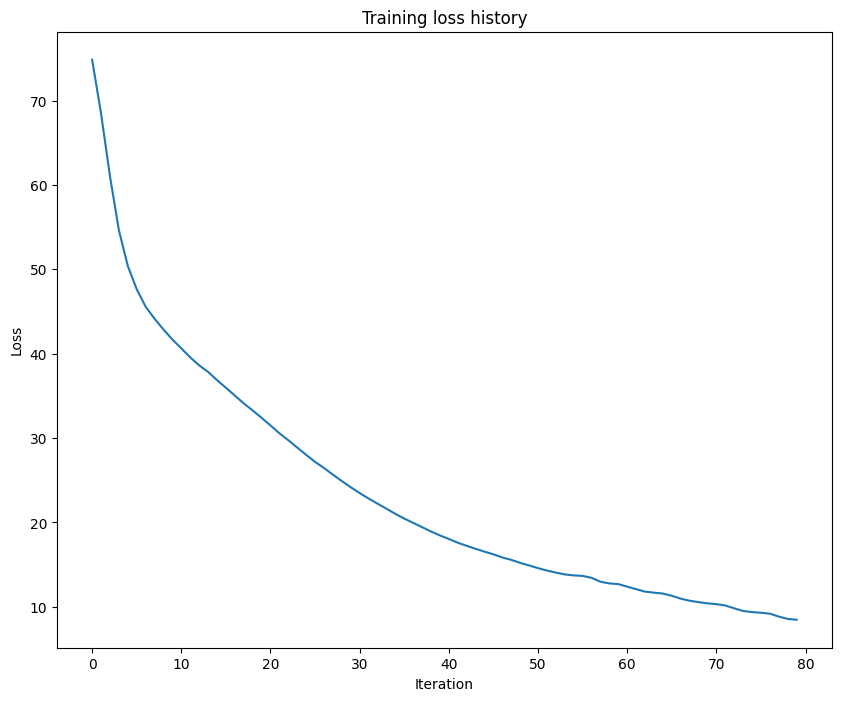

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train,).long()
small_image_data = data_dict['train_images'][sample_idx]
small_caption_data = data_dict['train_captions'][sample_idx]

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Modify the [`sample`](#scrollTo=v0M8Dq5NEOxN) method in module `CaptioningRNN` to handle the case where `self.cell_type` is `attention`. **This should take fewer than 10 lines of code.**

When you are done run the following to train a captioning model and sample from the model on some training and validation set samples.

### Train the net
Now, perform the training on the entire training set. You should see a final loss less than `1.0`.

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,))
small_image_data = data_dict['train_images'][sample_idx]
small_caption_data = data_dict['train_captions'][sample_idx]

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
attn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(attn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

learning rate is:  0.001
(Epoch 0 / 60) loss: 48.4759 time per epoch: 348.1s
(Epoch 1 / 60) loss: 46.7949 time per epoch: 439.9s
(Epoch 2 / 60) loss: 44.6335 time per epoch: 408.7s
(Epoch 3 / 60) loss: 41.7944 time per epoch: 378.5s
(Epoch 4 / 60) loss: 39.2418 time per epoch: 334.9s
(Epoch 5 / 60) loss: 37.0418 time per epoch: 323.0s
(Epoch 6 / 60) loss: 35.2132 time per epoch: 310.0s
(Epoch 7 / 60) loss: 33.4625 time per epoch: 318.5s
(Epoch 8 / 60) loss: 31.9220 time per epoch: 307.0s
(Epoch 9 / 60) loss: 30.5951 time per epoch: 320.5s
(Epoch 10 / 60) loss: 29.2980 time per epoch: 309.7s
(Epoch 11 / 60) loss: 27.9970 time per epoch: 318.2s
(Epoch 12 / 60) loss: 26.6018 time per epoch: 307.3s
(Epoch 13 / 60) loss: 25.2349 time per epoch: 320.0s
(Epoch 14 / 60) loss: 24.0381 time per epoch: 314.8s
(Epoch 15 / 60) loss: 22.7255 time per epoch: 325.1s
(Epoch 16 / 60) loss: 21.5984 time per epoch: 304.6s
(Epoch 17 / 60) loss: 20.4885 time per epoch: 308.0s
(Epoch 18 / 60) loss: 19.4421 t

### Test-time sampling and visualization
As with RNN and LSTM, the samples on training data should be very good; the samples on validation data will probably make less sense.

We use the `attention_visualizer` function to visualize the attended regions per generated word. Note that sometimes the attended regions (brighter) might not make much sense particially due to our low resolution image input. In real applications, the attended regions are more accurate.

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.

batch_size = 3
from torchvision.utils import make_grid
from torchvision import transforms

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  attn_model.eval()
  generated_captions, attn_weights_all = attn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

    tokens = generated_captions[i].split(' ')

    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))

    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Final checks
Make sure you run "Runtime -> Restart and run all..." to double check the RNN/LSTM code is still functioning well after all the changes you have made!